# Convolutional Features for Keras' Pretrained Neural Nets
### How many features for VGG19, InceptionV3, Xception, MobileNet, and ResNet 50 are zero?

This blog post looks into the output of several popular image classification. The model architecture has been implemented in Keras. Keras is high-level wrapper for the TensorFlow and Theano libraries. As an added bonus, Keras allows us to import these model architectures with weights derived from the ImageNet dataset.

There is documentation, including the original research papers for each model in the Applications section of the Keras Docs. However, for those of us who learn best through tinkering, you're in luck.

In [1]:
%matplotlib inline
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

import keras
from keras import backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet

from keras.applications.inception_v3 import preprocess_input as process_inception
from keras.applications.xception import preprocess_input as process_xception
from keras.applications.resnet50 import preprocess_input as process_resnet
from keras.applications.vgg19 import preprocess_input as process_vgg
from keras.applications.mobilenet import preprocess_input as process_mobile

Using TensorFlow backend.


In [2]:
def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()
    
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return model

def make_xception_conv(input_shape):
    base_model = Xception(input_shape=input_shape, 
                          weights='imagenet', 
                          include_top=False)
    base_model = freeze_model(base_model)
    return base_model

def make_resnet_conv(input_shape):
    base_model = ResNet50(input_shape=input_shape, 
                          weights='imagenet', 
                          include_top=False)
    base_model = freeze_model(base_model)
    return base_model

def make_inception_conv(input_shape):
    base_model = InceptionV3(input_shape=input_shape, 
                             weights='imagenet', 
                             include_top=False)
    base_model = freeze_model(base_model)
    return base_model

def make_vgg19_conv(input_shape):
    base_model = VGG19(input_shape=input_shape, 
                       weights='imagenet', 
                       include_top=False)
    base_model = freeze_model(base_model)
    return base_model

def make_mobile_conv(input_shape):
    base_model = MobileNet(input_shape=input_shape, 
                           weights='imagenet', 
                           include_top=False)
    base_model = freeze_model(base_model)
    return base_model

In [3]:
from urllib.request import urlopen
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def read_img_url(url):
    '''
    Given a valid URL, the url will be opened as a Pillow Image.
    The image is converted to jpg if it's a png or another format.
    '''
    try:
        with urlopen(url) as file:
            img = Image.open(file)
    except:
        print("Forbidden to open: {}".format(url))
        return None

    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    '''
    Resizes a Pillow image, and returns a NumPy array.
    '''''
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

## Let's Examine any Given Image from the Web.

In [4]:
url = 'http://i.imgur.com/P0eRT3y.jpg'
img_width, img_height = 224, 224

In [5]:
img = read_img_url(url)
np_img = resize_img_to_array(img, img_shape=(img_width, img_height))

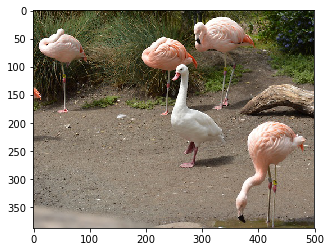

In [6]:
plt.imshow(img);

In [7]:
np_img.shape

(224, 224, 3)

In [8]:
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


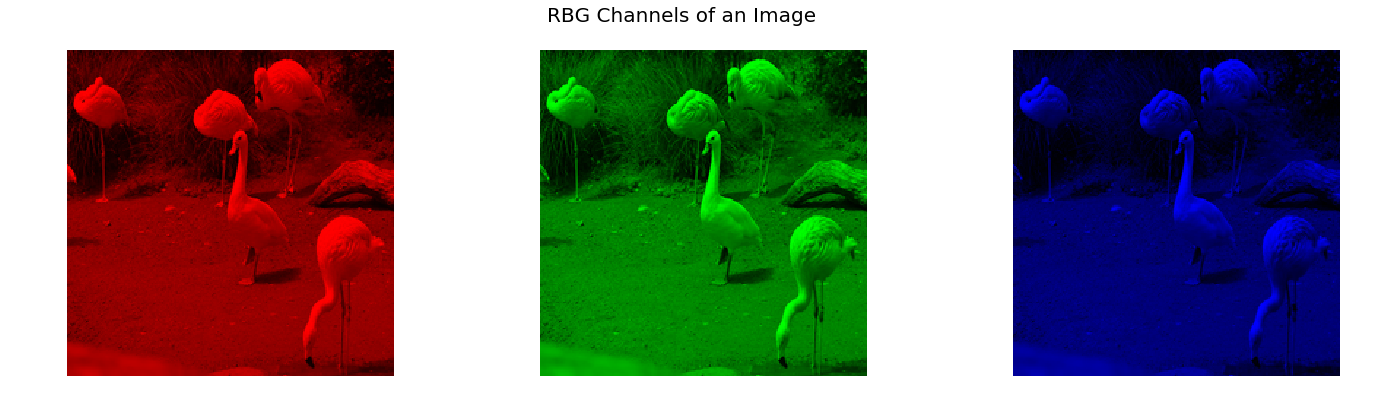

In [9]:
plot_channels(img)

In order to feed it into Keras, we need to expand the single image to an array.

In [10]:
np_img_expand = np.expand_dims(np_img, axis=0)
np_img_expand.shape

(1, 224, 224, 3)

In [48]:
def get_val(pred, model=None, img_url=None):
    '''
    For any single prediction, returns a dictionary of metrics
    about the shape, and contents of the predictions.
    '''
    feats = np.prod(pred.shape)
    z_feats = len(np.where(pred == 0)[0])
    
    vals = dict(
        model = model,
        img_url = img_url,
        shape = pred.shape,
        feats = feats,
        z_feats = z_feats,
        pz_feats = (feats - z_feats) / feats
    )
    
    return vals

def status(pred):
    '''
    Calls get val, then prints the results.
    '''
    val = get_val(pred)
    
    print('Convolutional features\n'
          'Shape: {}\n'
          'Num Features: {}\n'
          'Features that are Zero: {}\n'
          'Ratio Features that are non-Zero: {:.2f}'.format(
                val['shape'],
                val['feats'],
                val['z_feats'],
                val['pz_feats']
        )
    )

In [49]:
model = make_inception_conv((img_width, img_height, 3))
X = process_inception(np_img_expand.astype(np.float))
pred_inception = model.predict(X)
delete_model(model)

status(pred_inception[0])

Convolutional features
Shape: (5, 5, 2048)
Num Features: 51200
Features that are Zero: 34326
Ratio Features that are non-Zero: 0.33


In [13]:
model = make_xception_conv((img_width, img_height, 3))
X = process_xception(np_img_expand.astype(np.float))
pred_xception = model.predict(X)
delete_model(model)

status(pred_xception[0])

Convolutional features
Shape: (7, 7, 2048)
Num Features: 100352
Features that are Zero: 70827
Ratio Features that are non-Zero: 29.42


In [14]:
model = make_resnet_conv((img_width, img_height, 3))
X = process_resnet(np_img_expand.astype(np.float))
pred_resnet = model.predict(X)
delete_model(model)

status(pred_resnet[0])

Convolutional features
Shape: (1, 1, 2048)
Num Features: 2048
Features that are Zero: 303
Ratio Features that are non-Zero: 85.21


In [15]:
model = make_vgg19_conv((img_width, img_height, 3))
X = process_vgg(np_img_expand.astype(np.float))
pred_vgg19 = model.predict(X)
delete_model(model)

status(pred_vgg19[0])

Convolutional features
Shape: (7, 7, 512)
Num Features: 25088
Features that are Zero: 21182
Ratio Features that are non-Zero: 15.57


In [16]:
model = make_mobile_conv((img_width, img_height, 3))
X = process_mobile(np_img_expand.astype(np.float))
pred_mobile = model.predict(X)
delete_model(model)

status(pred_mobile[0])

Convolutional features
Shape: (7, 7, 1024)
Num Features: 50176
Features that are Zero: 40395
Ratio Features that are non-Zero: 19.49


### Let see if this trend is shared with other images?
Post URLs to any images from the web below.

In [17]:
img_urls = [
    'http://zhanghuan.stormking.org/images/works/OUTDOOR/ZH_OUT_3LEGGEDBUDDHA_WEB.jpg',
    'http://images.mentalfloss.com/wp-content/uploads/2008/08/legos.jpg',
    'http://static.kimkimcooking.com/wp-content/uploads/2013/10/DSC_9052_607_PS.jpg',
    'https://i.ytimg.com/vi/ttz4Sr0tZFg/maxresdefault.jpg',
    
    'https://media.wired.com/photos/59a459d3b345f64511c5e3d4/master/pass/MemeLoveTriangle_297886754.jpg',
    'https://static.boredpanda.com/blog/wp-content/uploads/2015/08/beautiful-unusual-sea-slugs-7__880.jpg',
    'https://i.ytimg.com/vi/btgNHZxiczY/maxresdefault.jpg',
    'https://lh3.googleusercontent.com/S1MCAPXY7q0TkDHG6faPL16dBgTnDX64nvMYtu19Ao17HftEMmr-DueZNAS_CtFkOlxo-nisy1j4H6J3FqRnZ0TNElcAJ1fIXvicsRuI5gbzwkGrUAnNTUrhPg'   
]

Let's read the urls into Pillow images, and append them to a list.

In [18]:
imgs = []
for url in img_urls:
    img = read_img_url(url)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    imgs.append(np_img)
imgs = np.array(imgs)

Let's look at the images:

In [19]:
def show_n(select_imgs, n=5, title=None):
    '''
    Displays n photos
    '''
    _ , ax = plt.subplots(1, n, sharex='col', sharey='row', figsize=(24, 6))
    if title:
        plt.suptitle(title, size=20)
    for i, img in enumerate(select_imgs):
        ax[i].imshow(img)
        ax[i].axis('off')

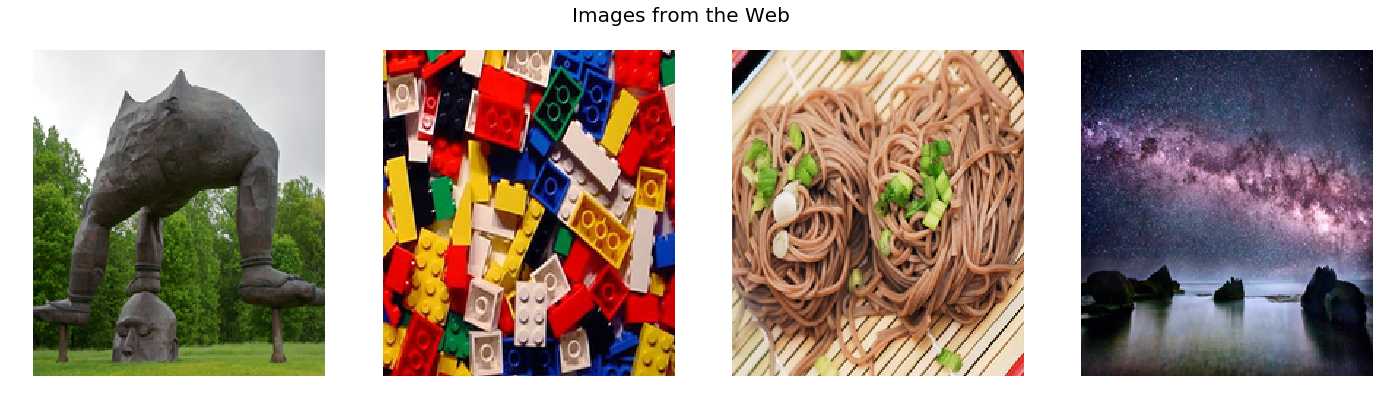

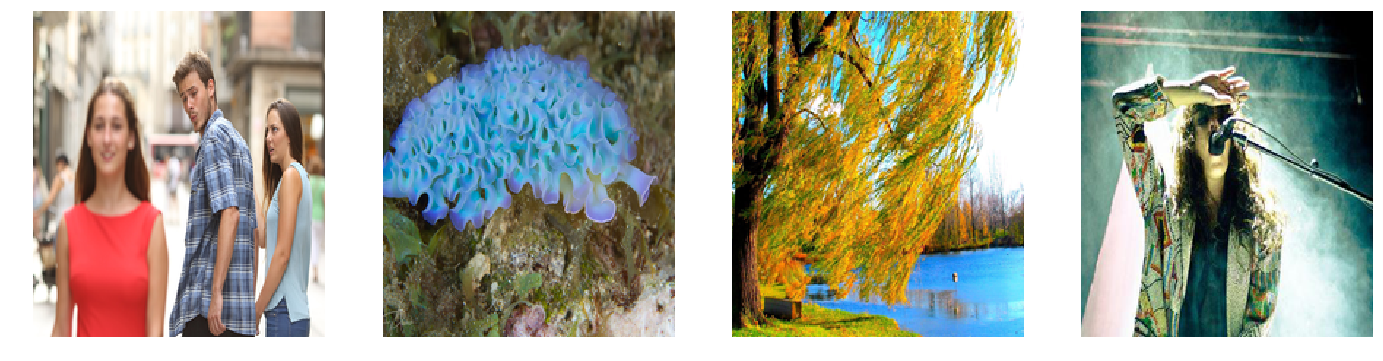

In [20]:
imgs_per_row = 4
for i, group in enumerate(zip(*(iter(imgs),) * imgs_per_row)):
    if i == 0:      
        show_n(group, n=imgs_per_row, title='Images from the Web')
    else:
        show_n(group, n=imgs_per_row)

In [21]:
imgs.shape

(8, 224, 224, 3)

In [56]:
def get_nullity(pred, model_name):
    '''
    Takes in an array of predictions.
    Checks the columns for consistent zero features.
    Returns a percentage of columns that are zero for all rows in the pred.
    '''
    shape = pred[0].shape
    feats = np.prod(pred.shape)
    non_zero = np.count_nonzero(pred)
    z_feats = feats - non_zero
    pz_feats = z_feats / feats
    
    # This flattens the predictions into 2 dimensions, 
    # and puts them into a Pandas dataframe.
    pred_2d = pd.DataFrame(
        pred.reshape(
            [ pred.shape[0], np.product(pred.shape[1:]) ]
        )
    )
    
    # This returns the number of columns for all 
    # predictions that contain zero.
    nullity = pred_2d.ix[:, (pred_2d == 0.0).all()].shape[-1] \
            / pred_2d.shape[-1]
    
    
    print('>>> {} Convolutional features\n'
          'Shape Conv Features per Image: {}\n'
          'Count Conv Features per Image: {}\n'
          'Frequency of Null Features: {:.2f}\n'
          'Nullity Ratio: {:.2f}'.format(
                model_name,
                shape,
                np.product(shape),
                pz_feats,
                nullity
        )
    )


In [57]:
evaluation = []

model = make_mobile_conv((img_width, img_height, 3))
X = process_mobile(imgs.astype(np.float))
pred_mobile = model.predict(X)
get_nullity(pred_mobile, '\nMobileNet')
delete_model(model)
for i, pred in enumerate(pred_mobile):
    evaluation.append(get_val(pred, 'MoblieNet', img_urls[i]))

model = make_vgg19_conv((img_width, img_height, 3))
X = process_vgg(imgs.astype(np.float))
pred_vgg19 = model.predict(X)
get_nullity(pred_vgg19, '\nVGG19')
delete_model(model)                    
for i, pred in enumerate(pred_vgg19):
    evaluation.append(get_val(pred, 'VGG19', img_urls[i]))
    
model = make_resnet_conv((img_width, img_height, 3))
X = process_resnet(imgs.astype(np.float))
pred_resnet = model.predict(X)
get_nullity(pred_resnet, '\nResNet50')
delete_model(model)
for i, pred in enumerate(pred_resnet):
    evaluation.append(get_val(pred, 'ResNet50', img_urls[i]))

model = make_xception_conv((img_width, img_height, 3))
X = process_inception(imgs.astype(np.float))
pred_xception = model.predict(X)
get_nullity(pred_xception, '\nXception')
delete_model(model)
for i, pred in enumerate(pred_xception):
    evaluation.append(get_val(pred, 'Xception', img_urls[i]))
 
model = make_inception_conv((img_width, img_height, 3))
X = process_inception(imgs.astype(np.float))
pred_inception = model.predict(X)
get_nullity(pred_inception, '\nInceptionV3')
delete_model(model)
for i, pred in enumerate(pred_inception):
    evaluation.append(get_val(pred, 'InceptionV3', img_urls[i]))

>>> 
MobileNet Convolutional features
Shape Conv Features per Image: (7, 7, 1024)
Count Conv Features per Image: 50176
Frequency of Null Features: 0.82
Nullity Ratio: 0.24
>>> 
VGG19 Convolutional features
Shape Conv Features per Image: (7, 7, 512)
Count Conv Features per Image: 25088
Frequency of Null Features: 0.87
Nullity Ratio: 0.38
>>> 
ResNet50 Convolutional features
Shape Conv Features per Image: (1, 1, 2048)
Count Conv Features per Image: 2048
Frequency of Null Features: 0.15
Nullity Ratio: 0.00
>>> 
Xception Convolutional features
Shape Conv Features per Image: (7, 7, 2048)
Count Conv Features per Image: 100352
Frequency of Null Features: 0.72
Nullity Ratio: 0.09
>>> 
InceptionV3 Convolutional features
Shape Conv Features per Image: (5, 5, 2048)
Count Conv Features per Image: 51200
Frequency of Null Features: 0.50
Nullity Ratio: 0.01


In [41]:
df = pd.DataFrame(evaluation)
df.head()

,feats,img_url,model,pz_feats,shape,z_feats
0,50176,http://zhanghuan.stormking.org/images/works/OU...,MoblieNet,20.268654,"(7, 7, 1024)",40006
1,50176,http://images.mentalfloss.com/wp-content/uploa...,MoblieNet,17.042012,"(7, 7, 1024)",41625
2,50176,http://static.kimkimcooking.com/wp-content/upl...,MoblieNet,19.359853,"(7, 7, 1024)",40462
3,50176,https://i.ytimg.com/vi/ttz4Sr0tZFg/maxresdefau...,MoblieNet,18.347417,"(7, 7, 1024)",40970
4,50176,https://media.wired.com/photos/59a459d3b345f64...,MoblieNet,16.812819,"(7, 7, 1024)",41740


In [42]:
model_code = {
    'MoblieNet': 0,
    'VGG19': .25,
    'Xception' : .5,
    'InceptionV3': .75,
    'ResNet50' : 1,
}

In [43]:
model_code.keys()

dict_keys(['MoblieNet', 'VGG19', 'Xception', 'InceptionV3', 'ResNet50'])

In [44]:
df['model_code'] = df['model'].replace(model_code)

In [45]:
df.sort_values(by=['model_code'], inplace=True)

In [59]:
df[df['img_url'] == img_urls[i]]

,feats,img_url,model,pz_feats,shape,z_feats,model_code
7,50176,https://lh3.googleusercontent.com/S1MCAPXY7q0T...,MoblieNet,20.041454,"(7, 7, 1024)",40120,0.00
15,25088,https://lh3.googleusercontent.com/S1MCAPXY7q0T...,VGG19,13.930963,"(7, 7, 512)",21593,0.25
31,100352,https://lh3.googleusercontent.com/S1MCAPXY7q0T...,Xception,38.601124,"(7, 7, 2048)",61615,0.50
39,51200,https://lh3.googleusercontent.com/S1MCAPXY7q0T...,InceptionV3,58.275391,"(5, 5, 2048)",21363,0.75
23,2048,https://lh3.googleusercontent.com/S1MCAPXY7q0T...,ResNet50,94.482422,"(1, 1, 2048)",113,1.00


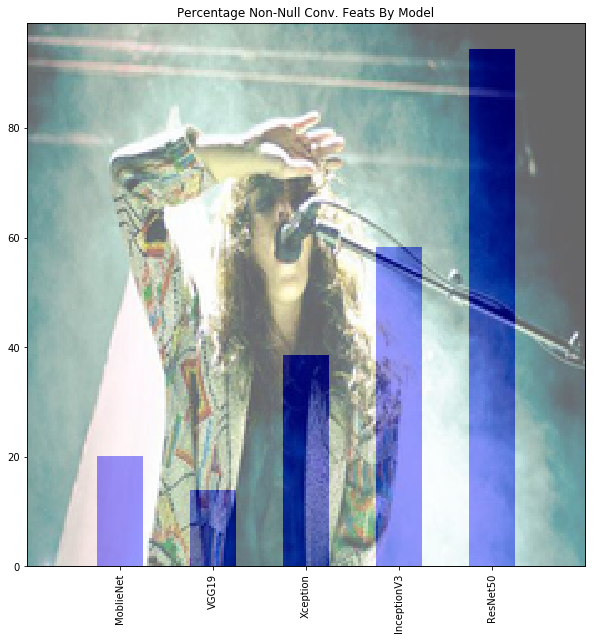

In [58]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
i = -1

df[df['img_url'] == img_urls[i]].plot(
    x='model_code',y='pz_feats', kind='bar', 
    alpha=1, color='b', ax=ax,
    title='Percentage Non-Null Conv. Feats By Model'
)

ax.set_xticklabels(model_code.keys())
ax.get_legend().set_visible(False)
ax.set_xlabel('asda').set_visible(False)

ax2 = ax.twinx()
ax2.imshow(imgs[i], zorder=1, extent=[-1, 5., 0, 6.], alpha=.6)
ax2.get_yaxis().set_visible(False)